In [25]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from scipy.stats import multivariate_normal

## モデルの作成

In [26]:
# 3000x3000の座標平面を作成
x = np.linspace(0, 3000, 3000)
y = np.linspace(0, 3000, 3000)
X, Y = np.meshgrid(x, y)

# 電波発信端末の座標とGMMのパラメータを設定
transmitter_1 = [500, 500]  # 端末1の平均 (中心座標)
transmitter_2 = [2500, 2500]  # 端末2の平均 (中心座標)

covariance_matrix_1 = [[500000, 0], [0, 500000]]  # 端末1の共分散行列
covariance_matrix_2 = [[500000, 0], [0, 500000]]  # 端末2の共分散行列

# 各発信端末のガウス分布を計算
rv1 = multivariate_normal(mean=transmitter_1, cov=covariance_matrix_1)
rv2 = multivariate_normal(mean=transmitter_2, cov=covariance_matrix_2)

# 各座標点での確率密度関数を計算
Z1 = rv1.pdf(np.dstack((X, Y)))
Z2 = rv2.pdf(np.dstack((X, Y)))

# 確率密度をRSSI値に変換
# RSSIの範囲を設定
RSSI_max = -30  # dBm
RSSI_min = -90  # dBm

# Z1とZ2の最大値
Z1_max = np.max(Z1)
Z2_max = np.max(Z2)

# 確率密度をRSSIにスケーリング
# 確率密度のグラデーションをそのままRSSI値に変換
RSSI1 = RSSI_min + (Z1 / Z1_max) * (RSSI_max - RSSI_min)
RSSI2 = RSSI_min + (Z2 / Z2_max) * (RSSI_max - RSSI_min)

## 実際にモデルを扱う

In [27]:
def get_rssi(
    x, y, X: NDArray[np.int64], Y: NDArray[np.int64], RSSI: NDArray[np.float64]
):
    # 座標の範囲チェック
    if x < X.min() or x > X.max() or y < Y.min() or y > Y.max():
        return None  # 座標が範囲外の場合はNoneを返す

    # 座標に最も近いインデックスを取得
    idx_x = (np.abs(X[0, :] - x)).argmin()
    idx_y = (np.abs(Y[:, 0] - y)).argmin()

    return RSSI[idx_y, idx_x]


def likelihood_function(rssi_input:float, RSSI: NDArray[np.float64], std_dev: float):
    # RSSI値と入力されたRSSI値との差を計算
    rssi_difference = RSSI - rssi_input

    # 尤度関数を計算
    likelihood = np.exp(-0.5 * (rssi_difference / std_dev) ** 2) / (
        std_dev * np.sqrt(2 * np.pi)
    )

    # 尤度を正規化して総和が1になるようにする
    likelihood /= np.sum(likelihood)

    return likelihood


# 標準偏差を計算するための関数
def calculate_std_dev(RSSI: NDArray[np.float64]) -> float:
    return np.std(RSSI)


# テスト用
rssi_input = -60
std_dev1 = calculate_std_dev(RSSI1)
std_dev2 = calculate_std_dev(RSSI2)

likelihood1 = likelihood_function(rssi_input, RSSI1, std_dev1)
likelihood2 = likelihood_function(rssi_input, RSSI2, std_dev2)


In [28]:
# 座標を入力して尤度を取得する関数
def get_likelihood(x, y, X, Y, likelihood):
    # 座標の範囲チェック
    if x < X.min() or x > X.max() or y < Y.min() or y > Y.max():
        return None  # 座標が範囲外の場合はNoneを返す

    # 座標に最も近いインデックスを取得
    idx_x = (np.abs(X[0, :] - x)).argmin()
    idx_y = (np.abs(Y[:, 0] - y)).argmin()

    return likelihood[idx_y, idx_x]

# テスト用
coords = [(500, 500), (2500, 2500), (1500, 1500), (3000, 3000)]

for x, y in coords:
    likelihood_value1 = get_likelihood(x, y, X, Y, likelihood1)
    likelihood_value2 = get_likelihood(x, y, X, Y, likelihood2)
    print(f"Coordinates: ({x}, {y}) -> Likelihood1: {likelihood_value1}, Likelihood2: {likelihood_value2}")


Coordinates: (500, 500) -> Likelihood1: 5.983119824694169e-08, Likelihood2: 5.995252747138856e-08
Coordinates: (2500, 2500) -> Likelihood1: 5.99525274713884e-08, Likelihood2: 5.983119824694183e-08
Coordinates: (1500, 1500) -> Likelihood1: 1.210610146566853e-07, Likelihood2: 1.213498041975837e-07
Coordinates: (3000, 3000) -> Likelihood1: 5.983254339541911e-08, Likelihood2: 2.5246349876291554e-07


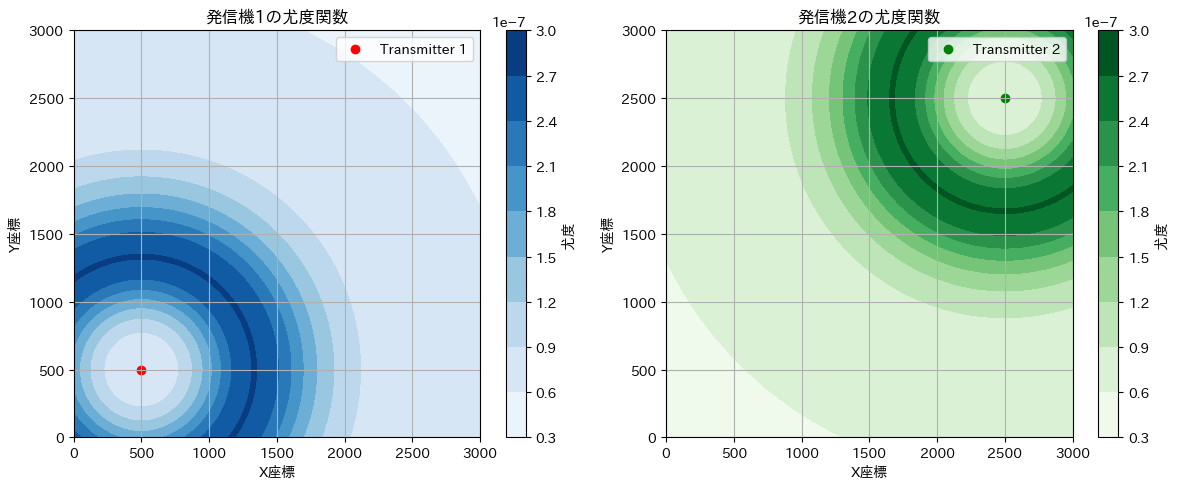

In [29]:
# プロットして確認
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, likelihood1, cmap="Blues")
plt.colorbar(label="尤度")
plt.scatter(
    transmitter_1[0], transmitter_1[1], color="red", marker="o", label="Transmitter 1"
)
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title("発信機1の尤度関数")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, likelihood2, cmap="Greens")
plt.colorbar(label="尤度")
plt.scatter(
    transmitter_2[0], transmitter_2[1], color="green", marker="o", label="Transmitter 2"
)
plt.xlabel("X座標")
plt.ylabel("Y座標")
plt.title("発信機2の尤度関数")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()